# Embedding Model using _sentance_transformer_

In this notebook, we explore the way that text with multiple words/tokens is encoded into an embedding vector using the popular [sentence_transformers library](https://sbert.net/index.html). We will Check:

* [OpenAI Embedding](#openai-embedding)
* [Open source encoder input embeddings](#open-source-encoder---input-embeddings)
* [Open source encoder output embedding (with context)](#open-source-encoder---output-embedding-with-context)
* [Improved encoder for queries and documents (bi-encoder)](#improved-encoder-for-queries-and-documents-bi-encoder)

Define rich theme for better object printing

In [1]:
from rich.console import Console
from rich_theme_manager import Theme, ThemeManager
import pathlib

theme_dir = pathlib.Path("themes")
theme_manager = ThemeManager(theme_dir=theme_dir)
dark = theme_manager.get("dark")

# Create a console with the dark theme
console = Console(theme=dark)


In [2]:
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

## OpenAI Embedding

A common option is to use the embedding from the same provider as the generation model.

In [3]:
first_sentence = "I have no interest in politics"

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [ ]:
from openai import OpenAI
client = OpenAI()

response = client.embeddings.create(
    input=first_sentence,
    model="text-embedding-3-small"
)

console.print(response)

## Open source encoder - input embeddings

We will start with one of the popular encoders from the _sentence_transformers_ library. It will allow us to explore its architecture and flow, and later on to optimize it to our use case.

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

### Model Tokenizer

We will use the default tokenizer of the model. Every word or subword is converted into a token with a constant ID. For example, in the following two sentences, the word `interest` is tokenized to the same ID (`3037`).

In [7]:
first_sentence = "I have no interest in politics"
second_sentence = "The bank's interest rate rises"


In [8]:
tokenized_first_sentence = model.tokenize([first_sentence])
console.rule(f"{first_sentence}")
console.print(tokenized_first_sentence)

───────────────────────────────────────── I have no interest in politics ──────────────────────────────────────────

{
    'input_ids': tensor([[ 101, 1045, 2031, 2053, 3037, 1999, 4331,  102]]),
    'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]),
    'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])
}

In [9]:
tokenized_second_sentence = model.tokenize([second_sentence])
console.rule(f"{second_sentence}")
console.print(tokenized_second_sentence)

───────────────────────────────────────── The bank's interest rate rises ──────────────────────────────────────────

{
    'input_ids': tensor([[ 101, 1996, 2924, 1005, 1055, 3037, 3446, 9466,  102]]),
    'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]]),
    'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

The token ID can be used to convert it back into readable text:

In [10]:
sentence_tokens = (
    model
    .tokenizer
    .convert_ids_to_tokens(
        tokenized_second_sentence["input_ids"]
        [0]
    )
)

console.print(sentence_tokens)

['[CLS]', 'the', 'bank', "'", 's', 'interest', 'rate', 'rises', '[SEP]']

### Model Vocabulary

In [11]:
vocabulary = (
    model
    ._first_module()
    .tokenizer
    .get_vocab()
    .items()
)

console.print("[bold]Vocabulary size[/bold]:", len(vocabulary))
console.print(dict(list(vocabulary)[:20]))

Vocabulary size: 30522

{
    'akira': 21616,
    'argentina': 5619,
    'zen': 16729,
    'closing': 5494,
    'screenwriter': 11167,
    'ke': 17710,
    'owl': 13547,
    '##sat': 16846,
    'offspring': 13195,
    'forgotten': 6404,
    'geelong': 18664,
    'bangladeshi': 24267,
    'etc': 4385,
    'kills': 8563,
    'since': 2144,
    'voter': 14303,
    'conqueror': 25466,
    '##nden': 25915,
    'span': 8487,
    'supplement': 12448
}

Let's see part of the tokenizer vocabulary. We will search for the token for `interest` and see its neighbors.


In [12]:


sorted_vocabulary = sorted(
    vocabulary, 
    key=lambda x: x[1],  # uses the value of the dictionary entry
)
sorted_tokens = [token for token, _ in sorted_vocabulary]

focused_token = 'interest'
# Find the index of the 'interest' token
focused_index = sorted_tokens.index(focused_token)

# Get 20 tokens around the focused token
start_index = max(0, focused_index - 10)
end_index = min(len(sorted_tokens), focused_index + 11)
tokens_around_focused_index = sorted_tokens[start_index:end_index]

from rich.table import Table

table = Table(title=f"Tokens around '{focused_token}':")
table.add_column("id", justify="right", style="cyan", no_wrap=True)
table.add_column("token", style="bright_green")

for i, token in enumerate(tokens_around_focused_index, start=start_index):
    if token == focused_token:
        table.add_row(f"[bold][black on yellow]{i}[/black on yellow][/bold]", f"[bold][black on yellow]{token}[/black on yellow][/bold]")
    else:
        table.add_row(str(i), token)

console.print(table)

     Tokens around     
      'interest':      
┏━━━━━━┳━━━━━━━━━━━━━━┓
┃   id ┃ token        ┃
┡━━━━━━╇━━━━━━━━━━━━━━┩
│ 3027 │ ft           │
│ 3028 │ valley       │
│ 3029 │ organization │
│ 3030 │ stopped      │
│ 3031 │ onto         │
│ 3032 │ countries    │
│ 3033 │ parts        │
│ 3034 │ conference   │
│ 3035 │ queen        │
│ 3036 │ security     │
│ 3037 │ interest     │
│ 3038 │ saying       │
│ 3039 │ allowed      │
│ 3040 │ master       │
│ 3041 │ earlier      │
│ 3042 │ phone        │
│ 3043 │ matter       │
│ 3044 │ smith        │
│ 3045 │ winning      │
│ 3046 │ try          │
│ 3047 │ happened     │
└──────┴──────────────┘

### The Embedding Transformer Model 

Transformer consists of multiple stack modules. Tokens are an input of the first one. Let's see that first model.

In [13]:
console.print(model)

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True,
'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': 
False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

In [14]:
first_module = model._first_module()
console.print(first_module.auto_model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=1536, out_features=384, bias=True)
          (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
  )
  (pooler): BertPooler(
    (dense): Linear(in_features=384, out_features=384, bias=True)
    (activation): Tanh()
  )
)

and focus on the `embeddings` part:

In [15]:
embeddings = first_module.auto_model.embeddings
console.print(embeddings)

BertEmbeddings(
  (word_embeddings): Embedding(30522, 384, padding_idx=0)
  (position_embeddings): Embedding(512, 384)
  (token_type_embeddings): Embedding(2, 384)
  (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

### Embedding Model Input Token IDs

We will send to the transformer model the two sentences above, and check the embedding similarity between the **input** tokens.

In [16]:
import torch

device = torch.device("mps" if torch.has_mps else "cpu")  # Use MPS for Apple, CUDA for others, or fallback to CPU

with torch.no_grad():
    # Tokenize both texts
    first_tokens = model.tokenize([first_sentence])
    second_tokens = model.tokenize([second_sentence])
    
    # Get the corresponding embeddings
    first_embeddings = embeddings.word_embeddings(
        first_tokens["input_ids"].to(device)
    )
    second_embeddings = embeddings.word_embeddings(
        second_tokens["input_ids"].to(device)
    )

console.print(first_embeddings.shape, second_embeddings.shape)

torch.Size([1, 8, 384])
torch.Size([1, 9, 384])

In [17]:
from rich.table import Table

table = Table(title="Embeddings Shape Explanation")

table.add_column("Text", style="cyan", no_wrap=True)
table.add_column("Batch Size", style="white")
table.add_column("Tokens Number", style="white")
table.add_column("Embedding Dimension", style="white")

table.add_row(
    first_sentence,
    str(first_embeddings.shape[0]),
    str(first_embeddings.shape[1]),
    str(first_embeddings.shape[2]),
)
table.add_row(
    second_sentence,
    str(second_embeddings.shape[0]),
    str(second_embeddings.shape[1]),
    str(second_embeddings.shape[2]),
)

console.print(table)

                            Embeddings Shape Explanation                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Text                           ┃ Batch Size ┃ Tokens Number ┃ Embedding Dimension ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ I have no interest in politics │ 1          │ 8             │ 384                 │
│ The bank's interest rate rises │ 1          │ 9             │ 384                 │
└────────────────────────────────┴────────────┴───────────────┴─────────────────────┘

### Compare the input embedding of the tokens

In [18]:
from sentence_transformers import util
import altair as alt
import pandas as pd

# Calculate cosine similarity
distances = util.cos_sim(
    first_embeddings.squeeze(), 
    second_embeddings.squeeze()
).cpu().numpy()

# Get token labels
x_labels = model.tokenizer.convert_ids_to_tokens(second_tokens["input_ids"][0])
y_labels = model.tokenizer.convert_ids_to_tokens(first_tokens["input_ids"][0])

# Create a DataFrame for Altair
data = pd.DataFrame(
    [(x, y, distances[i, j]) for i, y in enumerate(y_labels) for j, x in enumerate(x_labels)],
    columns=['x', 'y', 'similarity']
)

# Create heatmap using Altair
chart = alt.Chart(data).mark_rect().encode(
    x=alt.X('x:O', title='Second Sentence Tokens', axis=alt.Axis(labelAngle=-45), sort=x_labels),
    y=alt.Y('y:O', title='First Sentence Tokens', sort=y_labels),
    color=alt.Color('similarity:Q', scale=alt.Scale(scheme='yellowgreenblue')),
    tooltip=['x', 'y', alt.Tooltip('similarity:Q', format='.2f')]
).properties(
    width=500,
    height=400,
    title='Input Token Similarity Heatmap'
)

# Add text labels
text = chart.mark_text(baseline='middle').encode(
    text=alt.Text('similarity:Q', format='.2f'),
    color=alt.condition(
        alt.datum.similarity > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine chart and text
final_chart = (chart + text).configure_title(fontSize=16)

# Display the chart
final_chart

alt.LayerChart(...)

### Vocabulary Embedding

As we saw there are 30,522 tokens in the vocabulary, and each token is embedded with a vector of size 384.

In [19]:
token_embeddings = first_module.auto_model \
    .embeddings \
    .word_embeddings \
    .weight \
    .detach() \
    .cpu() \
    .numpy()

console.print(token_embeddings.shape)

(30522, 384)

### Reduce the embedding vectors to 2D for visualization

We will use the TSNE library to create a 2D visualization of the token embeddings, to allow us to see tokens that are close to one another.

This process can take about a minute or two, based on your CPU.

In [20]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric="cosine", random_state=42)
tsne_embeddings_2d = tsne.fit_transform(token_embeddings)
console.print(tsne_embeddings_2d.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(30522, 2)

### Token Embedding Visualization

Once we have the 384 dimension reduced to 2D, we can plot it to explore it.

In [21]:
token_colors = []
for token in sorted_tokens:
    if token[0] == "[" and token[-1] == "]": # Control Tokens
        token_colors.append("red")
    elif token.startswith("##"):            # Suffix Tokens
        token_colors.append("blue")
    else:
        token_colors.append("green")        # All Word Tokens

In [22]:
import altair as alt
import pandas as pd

# Enable VegaFusion data transformer to handle larger datasets
alt.data_transformers.enable("vegafusion")

# Create a DataFrame from the data
df = pd.DataFrame({
    'x': tsne_embeddings_2d[:, 0],
    'y': tsne_embeddings_2d[:, 1],
    'token': sorted_tokens,
    'color': token_colors
})

# Create the Altair chart
chart = alt.Chart(df).mark_circle(size=30).encode(
    x='x:Q',
    y='y:Q',
    color=alt.Color('color:N', scale=None),
    tooltip=['token:N']
).properties(
    width=600,
    height=900,
    title='Token Embeddings'
).interactive()

# Display the chart
chart

alt.Chart(...)

## Open source encoder - output embedding (with context)

Now let's see the token embeddings at the output of the transformer embedding model.

In [23]:
output_embedding = model.encode([first_sentence])
console.print(output_embedding.shape)

(1, 384)

In [24]:
output_token_embeddings = model.encode(
    [first_sentence], 
    output_value="token_embeddings"
)
console.print(output_token_embeddings[0].shape)

torch.Size([8, 384])

In [25]:
with torch.no_grad():
    first_tokens = model.tokenize([first_sentence])
    second_tokens = model.tokenize([second_sentence])
    
    first_output_embeddings = model.encode(
        [first_sentence], 
        output_value="token_embeddings"
    )
    second_output_embeddings = model.encode(
        [second_sentence], 
        output_value="token_embeddings"
    )

# Calculate cosine similarity
distances = util.cos_sim(
    first_output_embeddings[0], 
    second_output_embeddings[0]
)

### Visualize the **Output** Token Similarity

Similar to the way to visualized the similarity of the **Input** tokens from the embedding lookup table, we will visualize the similar of the same tokens from the **Output** of the transformer model, after it applied the positional encoding and the attention layers.

In [26]:


# Get token labels
x_labels = model.tokenizer.convert_ids_to_tokens(second_tokens["input_ids"][0])
y_labels = model.tokenizer.convert_ids_to_tokens(first_tokens["input_ids"][0])

# Create a DataFrame for Altair
data = pd.DataFrame(
    [(x, y, distances[i, j]) for i, y in enumerate(y_labels) for j, x in enumerate(x_labels)],
    columns=['x', 'y', 'similarity']
)

# Create heatmap using Altair
chart = alt.Chart(data).mark_rect().encode(
    x=alt.X('x:O', title='Second Sentence Tokens', axis=alt.Axis(labelAngle=-45), sort=x_labels),
    y=alt.Y('y:O', title='First Sentence Tokens', sort=y_labels),
    color=alt.Color('similarity:Q', scale=alt.Scale(scheme='yellowgreenblue', domain=[0, 1])),
    tooltip=['x', 'y', alt.Tooltip('similarity:Q', format='.2f')]
).properties(
    width=500,
    height=400,
    title='Output Token Similarity Heatmap'
)

# Add text labels
text = chart.mark_text(baseline='middle').encode(
    text=alt.Text('similarity:Q', format='.2f'),
    color=alt.condition(
        alt.datum.similarity > 0.5,
        alt.value('white'),
        alt.value('black')
    )
)

# Combine chart and text
final_chart = (chart + text).configure_title(fontSize=16)

# Display the chart
final_chart


alt.LayerChart(...)

In [27]:
# Calculate cosine distance between output embeddings
from sklearn.metrics.pairwise import cosine_distances
from rich.panel import Panel
from rich.table import Table

def calculate_sentence_similarity(first_sentence, second_sentence):

    first_embeddings = model.encode([first_sentence])
    second_embeddings = model.encode([second_sentence])

    # Reshape the embeddings to 2D arrays
    first_embedding_2d = first_embeddings.reshape(1, -1)
    second_embedding_2d = second_embeddings.reshape(1, -1)

    # Calculate cosine distance
    cosine_distance = cosine_distances(first_embedding_2d, second_embedding_2d)[0][0]

    # Note: Cosine distance is 1 - cosine similarity
    cosine_similarity = 1 - cosine_distance

    console.print(
        Panel(
            f"[cyan bold]First Sentence:[/cyan bold] {first_sentence}\n"
            f"[cyan bold]Second Sentence:[/cyan bold] {second_sentence}",
            title="[green bold]Similarity Calculation[/green bold]",
            expand=False,
            border_style="dim white"
        )
    )

    results = Table(title="Results")
    results.add_column("Metric", style="bold")
    results.add_column("Value", style="bold")
    results.add_row("Cosine Distance", f"{cosine_distance:.4f}", style="cyan")
    results.add_row("Cosine Similarity", f"{cosine_similarity:.4f}", style="bright_yellow")

    console.print(results)


In [28]:
calculate_sentence_similarity(first_sentence, second_sentence)

╭──────────── Similarity Calculation ─────────────╮
│ First Sentence: I have no interest in politics  │
│ Second Sentence: The bank's interest rate rises │
╰─────────────────────────────────────────────────╯

           Results            
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric            ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Cosine Distance   │ 0.9384 │
│ Cosine Similarity │ 0.0616 │
└───────────────────┴────────┘

In [29]:
third_sentence = "Chase increased its lending fees"

calculate_sentence_similarity(second_sentence, third_sentence)

╭───────────── Similarity Calculation ──────────────╮
│ First Sentence: The bank's interest rate rises    │
│ Second Sentence: Chase increased its lending fees │
╰───────────────────────────────────────────────────╯

           Results            
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Metric            ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Cosine Distance   │ 0.5655 │
│ Cosine Similarity │ 0.4345 │
└───────────────────┴────────┘

## Improved encoder for queries and documents (bi-encoder)

We will use [Contextual Document Embeddings (CDE)](https://huggingface.co/jxm/cde-small-v1), which is one of the trending models in the Hugging Face model repository.

In [ ]:
import transformers

improved_model = transformers.AutoModel.from_pretrained("jxm/cde-small-v1", trust_remote_code=True)
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")

In [31]:
console.print(improved_model)

DatasetTransformer(
  (first_stage_model): BiEncoder(
    (embedder): NomicBertModel(
      (embeddings): NomicBertEmbeddings(
        (word_embeddings): Embedding(30528, 768)
        (token_type_embeddings): Embedding(2, 768)
      )
      (emb_drop): Dropout(p=0.0, inplace=False)
      (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (encoder): NomicBertEncoder(
        (layers): ModuleList(
          (0-11): 12 x NomicBertBlock(
            (attn): NomicBertAttention(
              (rotary_emb): NomicBertRotaryEmbedding()
              (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
              (out_proj): Linear(in_features=768, out_features=768, bias=False)
              (drop): Dropout(p=0.0, inplace=False)
            )
            (mlp): NomciBertGatedMLP(
              (fc11): Linear(in_features=768, out_features=3072, bias=False)
              (fc12): Linear(in_features=768, out_features=3072, bias=False)
              (fc2): Linear(in_features=3072, out_features=768, bias=False)
              (norm): Identity()
            )
            (dropout1): Dropout(p=0.0, inplace=False)
            (norm1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (norm2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout2): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (second_stage_model): DatasetConditionedBiencoder(
    (backbone): NomicBertModel(
      (embeddings): NomicBertEmbeddings(
        (word_embeddings): Embedding(30528, 768)
        (token_type_embeddings): Embedding(2, 768)
      )
      (emb_drop): Dropout(p=0.0, inplace=False)
      (emb_ln): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (encoder): NomicBertEncoder(
        (layers): ModuleList(
          (0-11): 12 x NomicBertBlock(
            (attn): NomicBertAttention(
              (rotary_emb): NomicBertRotaryEmbedding()
              (Wqkv): Linear(in_features=768, out_features=2304, bias=False)
              (out_proj): Linear(in_features=768, out_features=768, bias=False)
              (drop): Dropout(p=0.0, inplace=False)
            )
            (mlp): NomciBertGatedMLP(
              (fc11): Linear(in_features=768, out_features=3072, bias=False)
              (fc12): Linear(in_features=768, out_features=3072, bias=False)
              (fc2): Linear(in_features=3072, out_features=768, bias=False)
              (norm): Identity()
            )
            (dropout1): Dropout(p=0.0, inplace=False)
            (norm1): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (norm2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout2): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
    (prompt_projection): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
      (2): Linear(in_features=768, out_features=6144, bias=True)
    )
    (output_projection): Sequential(
      (0): Linear(in_features=768, out_features=768, bias=True)
      (1): ReLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
)

In [32]:
from datasets import load_dataset

corpus = load_dataset("BeIR/fiqa", "corpus")["corpus"]
queries = load_dataset("BeIR/fiqa", "queries")["queries"]

### Dataset samples

Let's see some examples of of the [Financial Opinion Mining and Question Answering (FiQA) dataset](https://huggingface.co/datasets/BeIR/fiqa) documents and queries.

In [33]:
import pandas as pd
from tabulate import tabulate

console.rule("Corpus Sample")
print(tabulate( 
    corpus
    .to_pandas()
    .head(10)
    .assign(text_start=lambda x: x['text'].str[:100])
    .drop(columns=['text','title'])
    ,headers='keys', 
    tablefmt='github', 
    showindex=False
))


────────────────────────────────────────────────── Corpus Sample ──────────────────────────────────────────────────

|   _id | text_start                                                                                           |
|-------|------------------------------------------------------------------------------------------------------|
|     3 | I'm not saying I don't like the idea of on-the-job training too, but you can't expect the company to |
|    31 | So nothing preventing false ratings besides additional scrutiny from the market/investors, but there |
|    56 | You can never use a health FSA for individual health insurance premiums.  Moreover, FSA plan sponsor |
|    59 | Samsung created the LCD and other flat screen technology like OLED. a few years ago every flat scree |
|    63 | Here are the SEC requirements: The federal securities laws define the term accredited investor in    |
|   100 | "Only relevant to those with fantasy economy teams. Seriously, Rand's fictional works never translat |
|   108 | Futures contracts are a member of a larger class of financial assets called derivative

In [34]:
console.rule("Queries Sample")
print(tabulate( 
    queries
    .to_pandas()
    .head(10)
    .assign(text_start=lambda x: x['text'].str[:100])
    .drop(columns=['text','title'])
    ,headers='keys', 
    tablefmt='github',
    showindex=False
))

───────────────────────────────────────────────── Queries Sample ──────────────────────────────────────────────────

|   _id | text_start                                                                                        |
|-------|---------------------------------------------------------------------------------------------------|
|     0 | What is considered a business expense on a business trip?                                         |
|     4 | Business Expense - Car Insurance Deductible For Accident That Occurred During a Business Trip     |
|     5 | Starting a new online business                                                                    |
|     6 | “Business day” and “due date” for bills                                                           |
|     7 | New business owner - How do taxes work for the business vs individual?                            |
|     9 | Hobby vs. Business                                                                                |
|    11 | Personal checks instead of business ones                                                          |
|    12 | 

## Stage 1: Gather dataset embeddings

CDE works by first getting a set of embeddings from corpus documents that is intended to be representative of the overall corpus. We first sample a number of documents from the corpus (this model is trained with 512 documents from each context) and get their embeddings from our first-stage model.

In [35]:
query_prefix = "search_query: "
document_prefix = "search_document: "

In [36]:
import random

def process_ex_document(ex: dict) -> dict:
  ex["text"] = f"{ex['title']} {ex['text']}"
  return ex

corpus_size = improved_model.config.transductive_corpus_size
console.print(f"Choosing {corpus_size} out of {len(corpus)} documents")
minicorpus_docs = corpus.select(random.choices(list(range(len(corpus))), k=corpus_size))
minicorpus_docs = minicorpus_docs.map(process_ex_document)["text"]
minicorpus_docs = tokenizer(
    [document_prefix + doc for doc in minicorpus_docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

Choosing 512 out of 57638 documents

Map: 100%|██████████| 512/512 [00:00<00:00, 17373.62 examples/s]


In [37]:
import torch
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
model.to(device)
minicorpus_docs = minicorpus_docs.to(device)

In [38]:
import torch
from tqdm.autonotebook import tqdm

batch_size = 32

dataset_embeddings = []
for i in tqdm(range(0, len(minicorpus_docs["input_ids"]), batch_size)):
    minicorpus_docs_batch = {k: v[i:i+batch_size] for k,v in minicorpus_docs.items()}
    with torch.no_grad():
        dataset_embeddings.append(
            improved_model.first_stage_model(**minicorpus_docs_batch)
        )

dataset_embeddings = torch.cat(dataset_embeddings)

100%|██████████| 16/16 [01:20<00:00,  5.03s/it]


## Stage 2: Embed in context

Now that we have dataset embeddings, we can use them to embed queries and documents like normal. We just need to provide an extra argument (`dataset_embeddings` in the CDE code).

In [39]:
sample_docs = corpus.select(range(16)).map(process_ex_document)["text"]

docs_tokens = tokenizer(
    [document_prefix + doc for doc in sample_docs],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  doc_embeddings = improved_model.second_stage_model(
      input_ids=docs_tokens["input_ids"],
      attention_mask=docs_tokens["attention_mask"],
      dataset_embeddings=dataset_embeddings,
  )
doc_embeddings /= doc_embeddings.norm(p=2, dim=1, keepdim=True)

In [40]:
queries_sample = queries.select(range(16))["text"]
queries_tokens = tokenizer(
    [query_prefix + query for query in queries_sample],
    truncation=True,
    padding=True,
    max_length=512,
    return_tensors="pt"
).to(device)

with torch.no_grad():
  query_embeddings = improved_model.second_stage_model(
      input_ids=queries_tokens["input_ids"],
      attention_mask=queries_tokens["attention_mask"],
      dataset_embeddings=dataset_embeddings,
  )
query_embeddings /= query_embeddings.norm(p=2, dim=1, keepdim=True)

### Models Comparison

Let's compare the two models (basic and improved with context) on the samples of the documents and queries.

In [41]:
with torch.no_grad():
  doc_basic_embeddings = model.encode(sample_docs)


In [42]:
with torch.no_grad():
  queries_basic_embeddings = model.encode(queries_sample)

─────────────────────────────────────────── Embedding Model Comparison ────────────────────────────────────────────

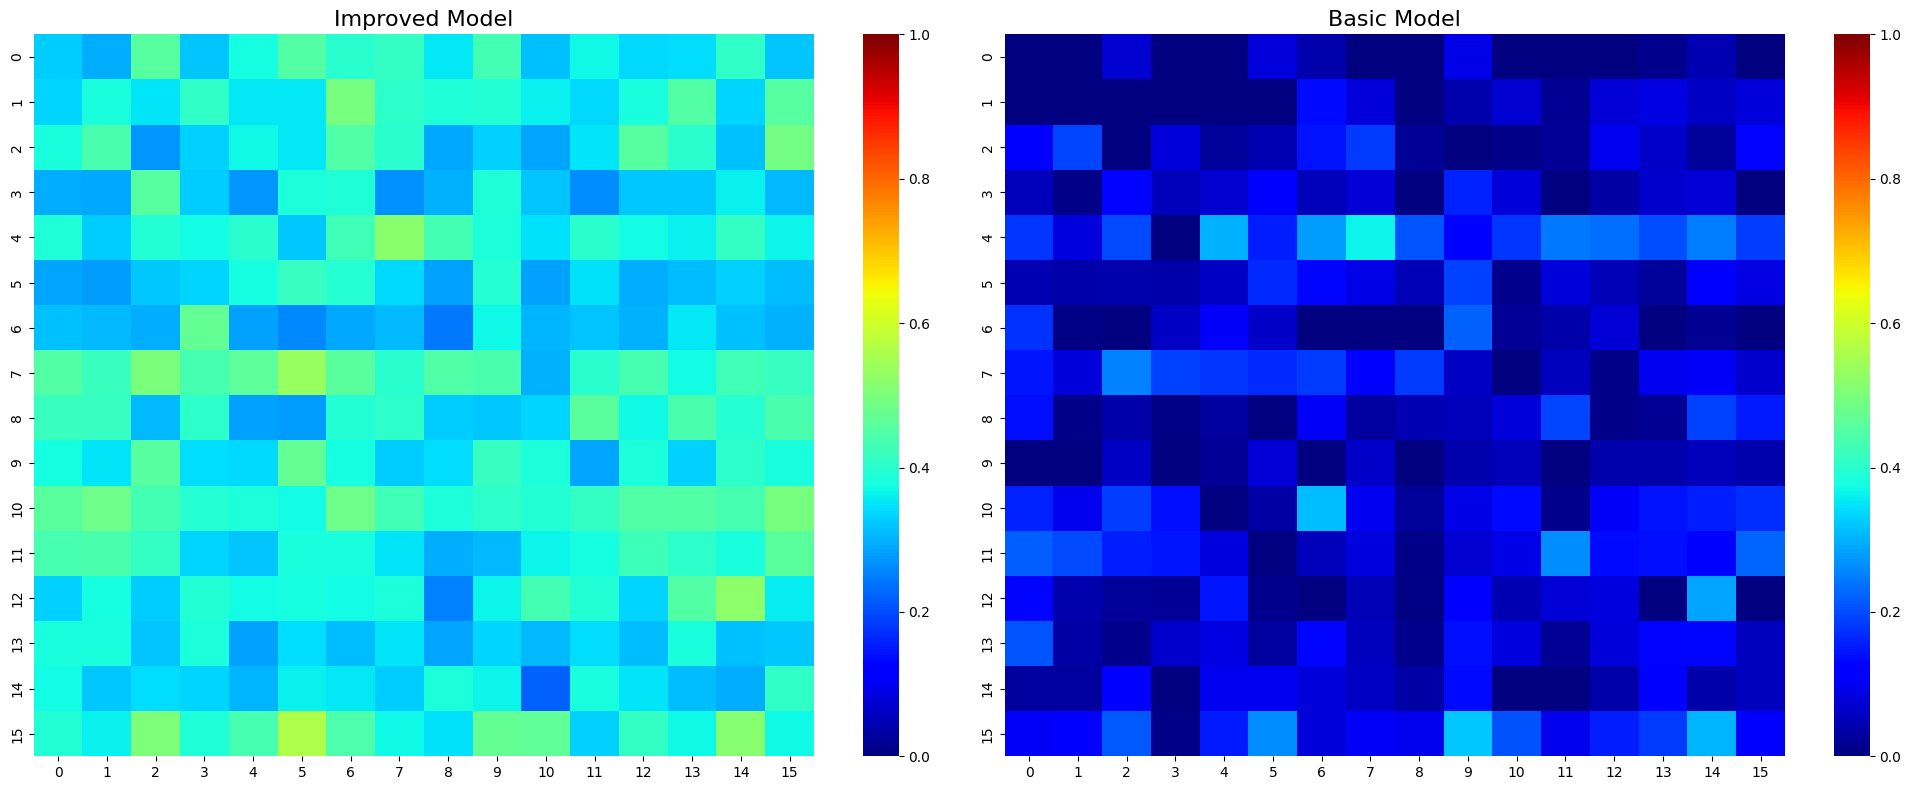

In [43]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap for improved model
sns.heatmap((doc_embeddings @ query_embeddings.T).cpu(), cmap="jet", ax=ax1, vmin=0, vmax=1)
ax1.set_title("Improved Model", fontsize=16)

# Heatmap for basic model
sns.heatmap((doc_basic_embeddings @ queries_basic_embeddings.T), cmap="jet", ax=ax2 ,vmin=0, vmax=1)
ax2.set_title("Basic Model", fontsize=16)

plt.tight_layout()
console.rule("Embedding Model Comparison")
plt.show()